In [1]:
# Import our module containing helper functions
import gravann

# Core imports
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

Available devices  10
__pyTorch VERSION: 2.4.1
__CUDNN VERSION: 90100
__Number CUDA Devices: 10
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


/home/pietrofanti/miniforge3/envs/geodesynet/lib/python3.8/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789259345/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [2]:
# one of "eros", "bennu", "itokawa", "churyumov-gerasimenko", "planetesimal", "torus", "bennu_nu", "itokawa_nu", "planetesimal_nu"
name_of_gt = "bennu"

In [3]:
# We load the ground truth (a mascon model of some body)
with open("mascons/"+name_of_gt+".pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses = torch.tensor(mascon_masses)

# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of mascons: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

# Each mascon has a closest neighbour. The least close one is here computed (non dimensional units).
# Its a quantity that is of interest when checking mascon models coming from gravitationally stable aggregates.
print("Maximal minimal distance:",gravann.max_min_distance(mascon_points))

Name:  Bennu
Number of mascons:  37799
Total mass:  tensor(1.0000, dtype=torch.float64)
Maximal minimal distance: 0.13160134851932526


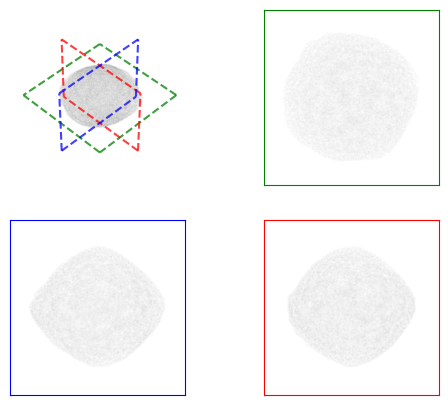

In [4]:
# Here we visualize the loaded ground truth
gravann.plot_mascon(mascon_points, mascon_masses,alpha=0.005)

In [5]:
# Models can be trained using direct_training.py with the line arguments specified in the following dict
models = [
    {
        "name": "9x100 (default)",
        "checkpoint_name": "bennu__classic_long",
        "type": "siren",
        "n_layers": 9,
        "n_neurons": 100
    },
    {
        "name": "9x100 quadratic",
        "checkpoint_name": "bennu__quadratic_long",
        "type": "siren_q",
        "n_layers": 9,
        "n_neurons": 100
    },
    {
        "name": "9x135",
        "checkpoint_name": "bennu__less_wider_long",
        "type": "siren",
        "n_layers": 9,
        "n_neurons": 135
    },
    {
        "name": "9x175",
        "checkpoint_name": "bennu__wider_long",
        "type": "siren",
        "n_layers": 9,
        "n_neurons": 175
    },
    {
        "name": "7x65 quadratic",
        "checkpoint_name": "bennu__quadratic_small_long",
        "type": "siren_q",
        "n_layers": 7,
        "n_neurons": 65
    },
    {
        "name": "7x135",
        "checkpoint_name": "bennu__135_7_long",
        "type": "siren",
        "n_layers": 7,
        "n_neurons": 135
    },
]

encoding = gravann.direct_encoding()


In [6]:
for m in models:
    m["model"] = gravann.init_network(
        encoding, n_neurons=m["n_neurons"], model_type=m["type"], activation=gravann.AbsLayer(), hidden_layers=m["n_layers"]
    )
    m["model"].load_state_dict(torch.load("models/"+m["checkpoint_name"]+".mdl"))
    m["c"] = gravann.compute_c_for_model(m["model"], encoding, mascon_points, mascon_masses, use_acc = True)
    m["model"].to(device="cpu")
    t = 0
    for p in m["model"].parameters():
        t += p.numel()
    m["n_parameters"] = t
    with open("logs/"+m["checkpoint_name"]+".pkl", 'rb') as f:
        log_dict = pk.load(f)
    for k,v in log_dict.items():
        m[k] = v

/home/pietrofanti/miniforge3/envs/geodesynet/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789259345/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [8]:
for m in models:
    print(m["name"])
    print(f"\thidden layers: {m['n_layers']}")
    print(f"\tneurons per layer: {m['n_neurons']}")
    print(f"\tquadratic layers: {m['type'] == 'siren_q'}")
    print(f"\tnumber of parameters: {m['n_parameters']}")
          

9x100 (default)
	hidden layers: 9
	neurons per layer: 100
	quadratic layers: False
	number of parameters: 91401
9x100 quadratic
	hidden layers: 9
	neurons per layer: 100
	quadratic layers: True
	number of parameters: 274203
9x135
	hidden layers: 9
	neurons per layer: 135
	quadratic layers: False
	number of parameters: 165916
9x175
	hidden layers: 9
	neurons per layer: 175
	quadratic layers: False
	number of parameters: 278076
7x65 quadratic
	hidden layers: 7
	neurons per layer: 65
	quadratic layers: True
	number of parameters: 91068
7x135
	hidden layers: 7
	neurons per layer: 135
	quadratic layers: False
	number of parameters: 129196


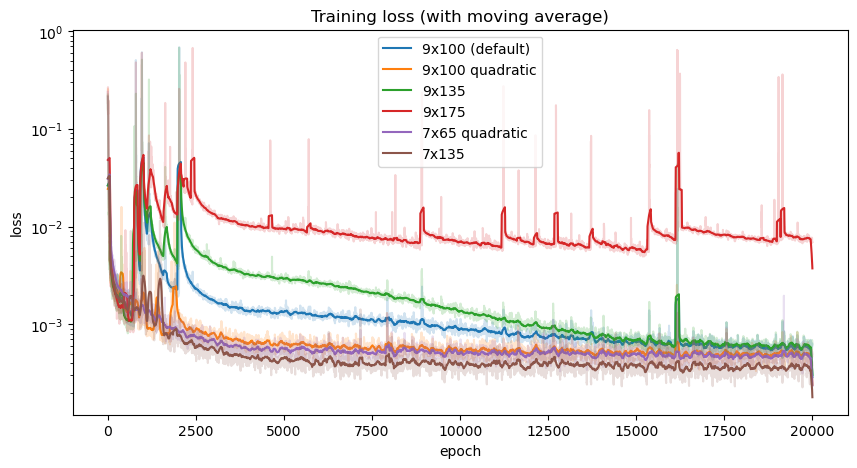

In [10]:
fig = plt.figure(figsize=(10, 5), dpi=100, facecolor='white')
ax0 = fig.add_subplot(111)
for i, m in enumerate(models):
    ax0.plot(m["loss"], alpha=0.2, color=f"C0{i}")
    ax0.plot(movingaverage(m["loss"], 100), color=f"C0{i}", label=m["name"])
ax0.legend()
ax0.set_title("Training loss (with moving average)")
ax0.set_xlabel("epoch")
ax0.set_ylabel("loss")
ax0.set_yscale("log")

Sampling points...: 1842it [00:00, 5679.25it/s]                         
Sampling points...: 1811it [00:00, 5639.66it/s]                         
Sampling points...: 1855it [00:00, 5887.81it/s]                         
Sampling points...: 1766it [00:00, 5651.76it/s]                         
Sampling points...: 1833it [00:00, 5782.47it/s]                         
Sampling points...: 1846it [00:00, 5814.04it/s]                         


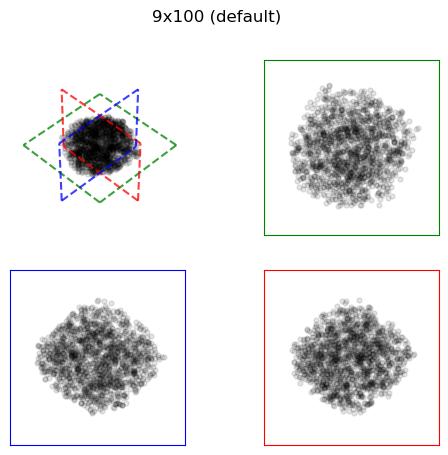

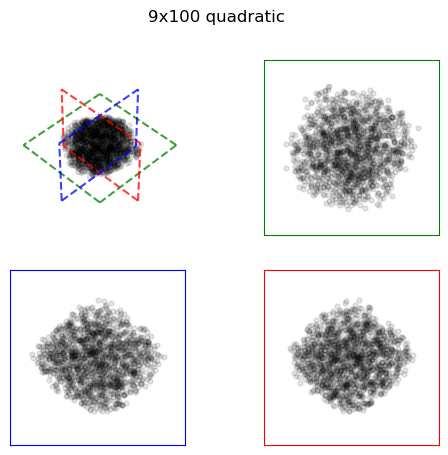

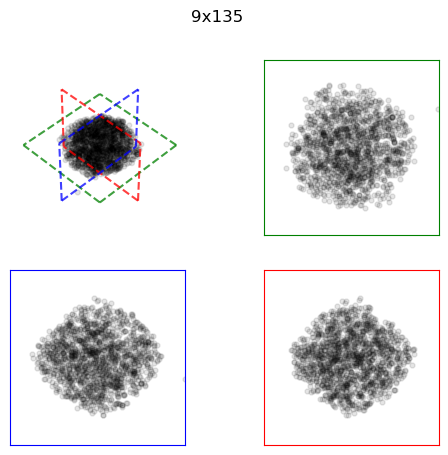

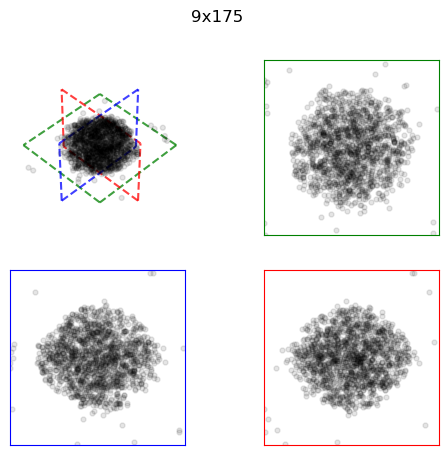

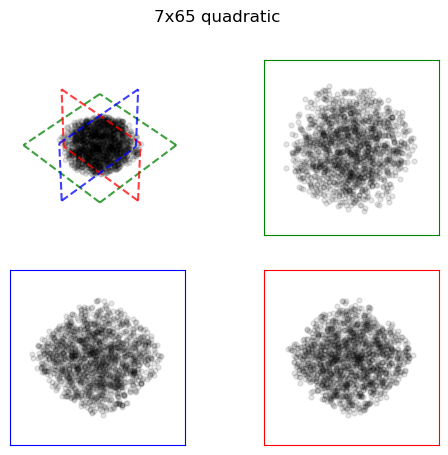

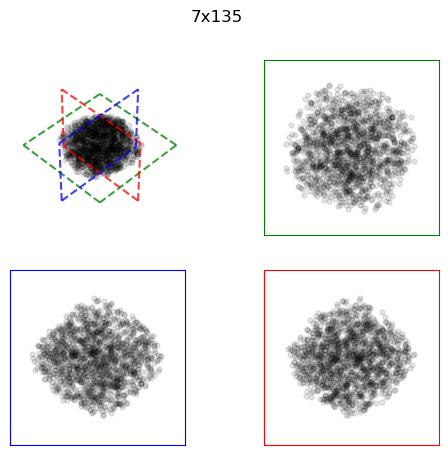

In [11]:
for m in models:
    m["model"].to(device=device)
    fig = gravann.plot_model_rejection(m["model"], encoding, views_2d=True, bw=True, N=1500, alpha=0.1, s=50, c=m["c"], crop_p=0.1, progressbar=True)
    m["model"].to(device="cpu")
    fig.suptitle(m["name"])

Sampling points...: 5437it [00:00, 6102.93it/s]                          
Sampling points...: 5460it [00:01, 5322.01it/s]                          
Sampling points...: 5155it [00:00, 5481.90it/s]                          
Sampling points...: 5090it [00:00, 5265.98it/s]                          
Sampling points...: 5140it [00:00, 5308.23it/s]                          
Sampling points...: 5168it [00:00, 6313.07it/s]                          


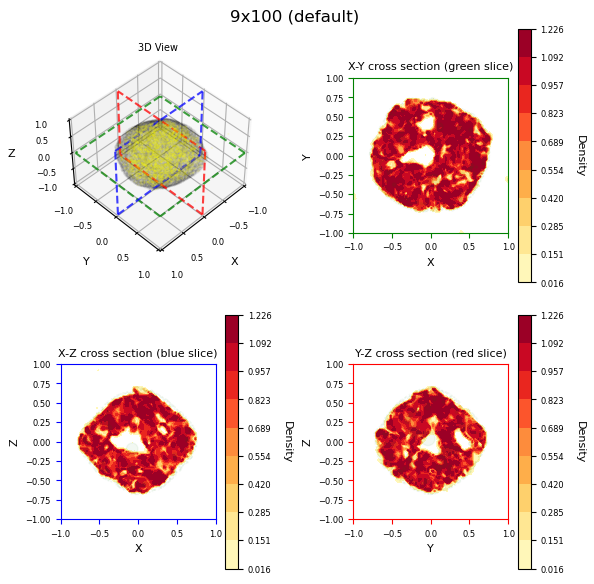

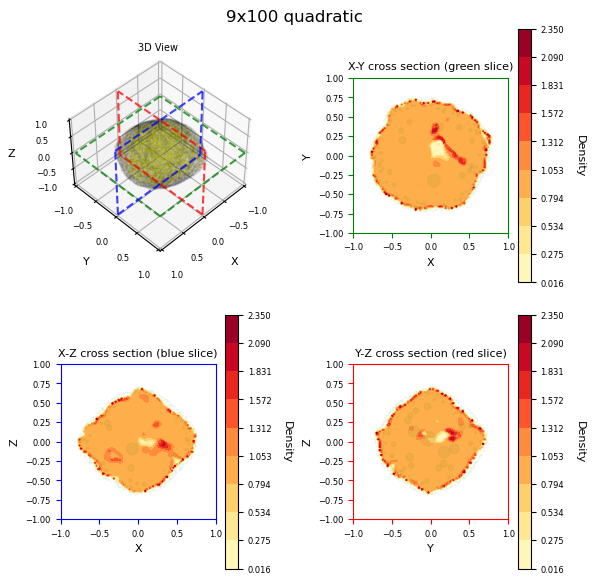

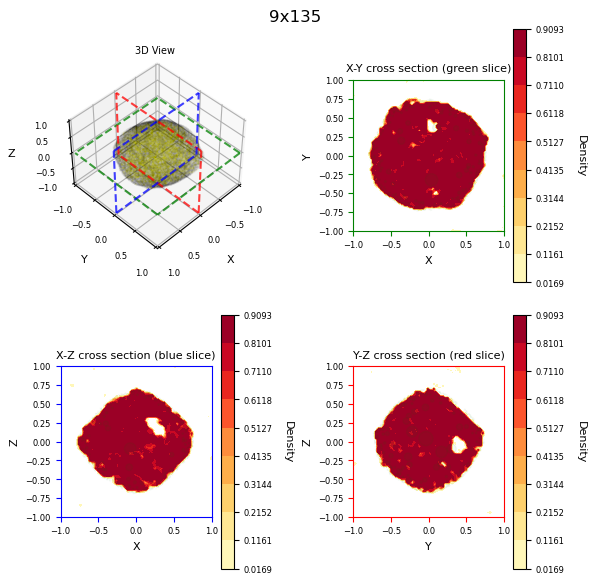

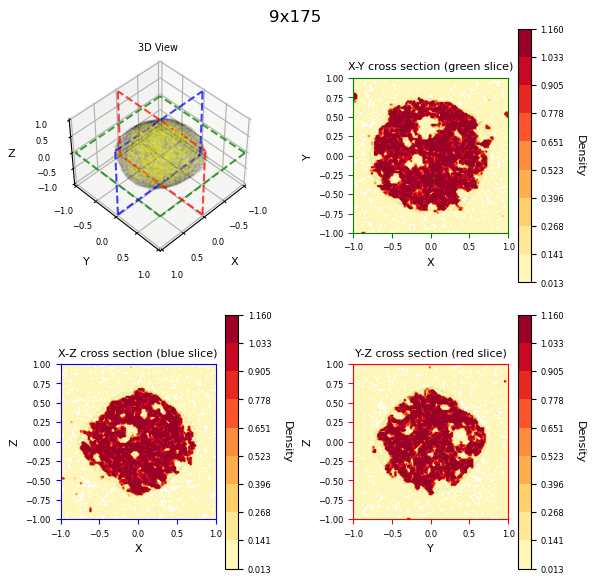

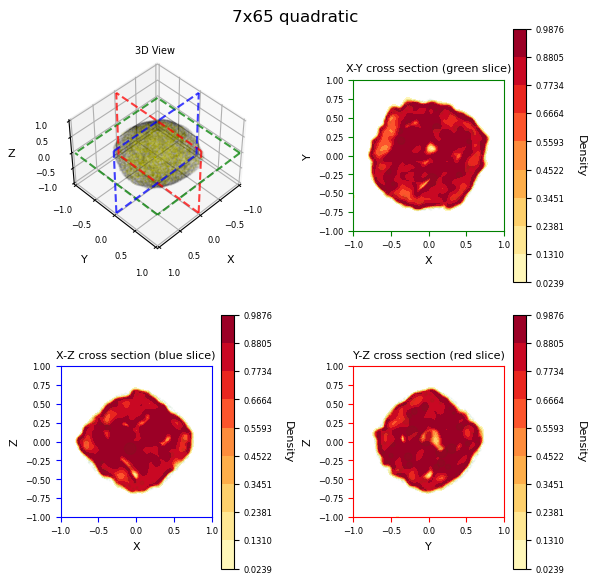

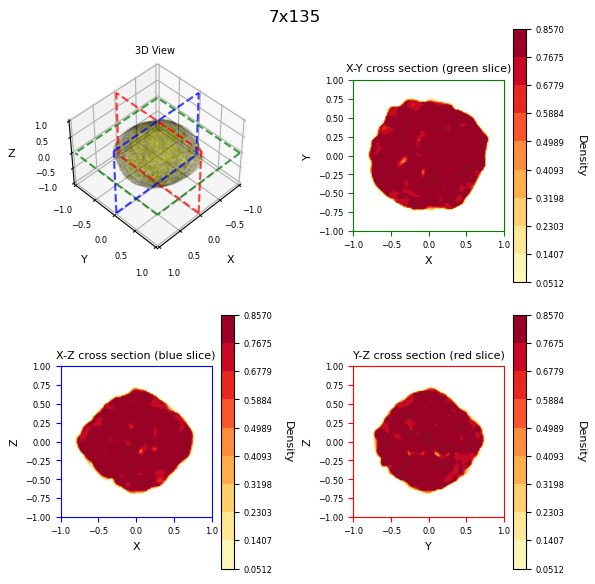

In [12]:
for m in models:
    m["model"].to(device=device)
    fig = gravann.plot_model_vs_mascon_contours(m["model"], encoding, mascon_points, mascon_masses,c=m["c"], progressbar = True, N=5000, heatmap=True)
    m["model"].to(device="cpu")
    plt.suptitle(m["name"])